# DES SN 5YR Tutorial Part 4: Hubble Diagram from DES 5YR

<img align="left" src = ../_static/images/logo044.jpg width=120 style="padding: 10px"> 
<br><b>Dark Energy Survey Supernova Program</b>

<b>Tutorial Part 4</b>
<b>Hubble Diagram</b> <br>
Contact author: Maria Vincenzi<br>

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as cols

from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.cosmology import FlatwCDM, Flatw0waCDM

Best fit cosmologies as reported in our publications (SN only)

In [3]:
FlatLCDM_bfit = FlatwCDM(Om0=0.352, H0=70)
FlatwCDM_bfit = FlatwCDM(Om0=0.264, H0=70, w0=-0.8)
Flatw0waCDM_bfit = Flatw0waCDM(Om0=0.495, H0=70, w0=-0.36, wa=-8.8)
Planck_bf = FlatwCDM(Om0=0.315, H0=70)

Let's load the Hubble Diagram files

In [4]:
from dessndr import data, utils

In [5]:
HD = pd.read_csv(
    os.path.join(data.DES5YRDR_DATA, '4_DISTANCES_COVMAT/DES-SN5YR_HD+MetaData.csv')
)
HD.drop(labels=['CID'], axis=1, inplace=True)

In [6]:
HD.head()

,CIDint,IDSURVEY,TYPE,zHEL,zHELERR,zCMB,zCMBERR,zHD,zHDERR,VPEC,...,PROB_SNIRFV19,PROB_SNNDESCC,PROB_SNNJ17,PROB_SNNV19,MU,MUERR_FINAL,PROBCC_BEAMS,biasCor_mu,biasCor_muCOVSCALE,biasCor_muCOVADD
0,1246275,10,0,0.24651,0.001,0.24605,0.001,0.24605,0.00160,0.0,...,0.8486,1.0000,0.9999,1.0000,40.5938,0.0968,0.0,0.0341,1.0,0.0050
1,1246281,10,0,0.33600,0.001,0.33549,0.001,0.33549,0.00167,0.0,...,1.0000,1.0000,0.9999,1.0000,41.2263,0.1360,0.0,-0.0492,1.0,0.0136
2,1246314,10,0,0.38388,0.001,0.38337,0.001,0.38337,0.00171,0.0,...,0.7823,0.9993,0.9970,0.9998,41.6383,0.2332,0.0,0.0502,1.0,0.0348
3,1246527,10,0,0.32184,0.001,0.32078,0.001,0.32078,0.00166,0.0,...,1.0000,0.9997,0.9998,1.0000,41.1991,0.1503,0.0,-0.0511,1.0,0.0173
4,1246529,10,0,0.49797,0.001,0.49677,0.001,0.49677,0.00180,0.0,...,0.9407,0.9996,0.9993,1.0000,42.1471,0.1618,0.0,-0.0485,1.0,0.0095


First we are going to remove any constant offset from the Hubble residuals

In [7]:
weights = 1./(HD.MUERR_FINAL.values**2)
offset = np.average(
    HD.MU.values - FlatwCDM_bfit.distmod(HD.zHD.values).value, 
    weights=weights
)
HD['myMURES'] = HD.MU.values - FlatwCDM_bfit.distmod(HD.zHD.values).value - offset

We are going to split the sample of DES and non-DES samples, also select the probability column to use

In [8]:
des5yr= HD[HD.IDSURVEY==10].copy()
lowz= HD[HD.IDSURVEY!=10]

In [9]:
Prob_column = "PROB_SNNV19"

In [10]:
def MU_weighted_average(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_, sum_w = np.average(df_grouped.MU.values, weights=w, returned=True)
    return avg_

In [11]:
def MU_weighted_average_err(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_, sum_w = np.average(df_grouped.MU.values, weights=w, returned=True)
    avg_err = np.std(df_grouped.MU.values)/np.sqrt(len(df_grouped.MU.values))
    return avg_err

In [12]:
def MURES_weighted_average(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_, sum_w = np.average(df_grouped.myMURES.values, weights=w, returned=True)
    return avg_

In [13]:
def MURES_weighted_average_err(df_grouped):
    w = 1./df_grouped.MUERR_FINAL.values**2
    avg_, sum_w = np.average(df_grouped.myMURES.values, weights=w, returned=True)
    avg_err = np.std(df_grouped.myMURES.values)/np.sqrt(len(df_grouped.myMURES.values))
    return avg_err

Set color maps and marker colors to match our paper colors

In [14]:
lowz_color='#D04A07'
des_color='#236CA7'
norm = cols.Normalize(-1,1)
colors = [[norm(-1.0), '#b4d7e8'], [norm( 1.0), '#236CA7']]
mycmap = cols.LinearSegmentedColormap.from_list("", colors)

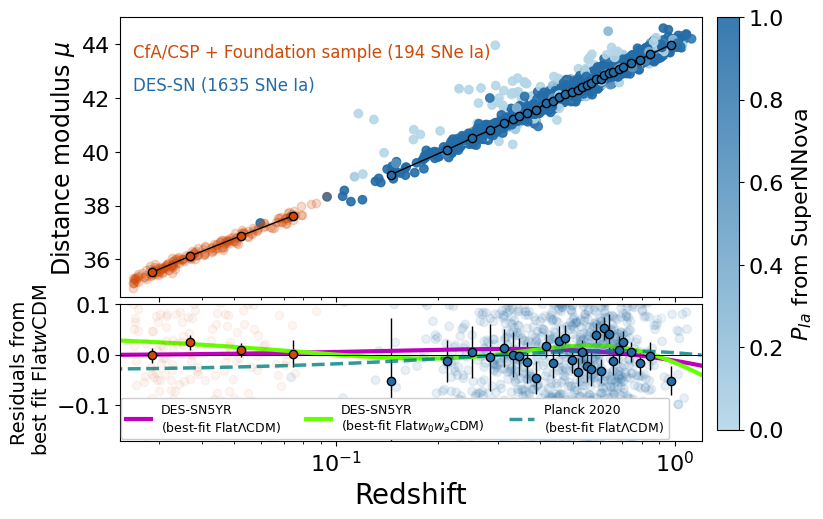

In [15]:
fig=plt.figure(figsize=(7.5,5.5))

### Hubble Diagram: Upper panel ###

a1 = plt.subplot2grid((3,1),(0,0),rowspan = 2)
plt.errorbar(des5yr.zHD.values, des5yr.MU.values, 
             fmt='o', mfc='None', mec='None', ecolor=des_color, alpha=0.2, zorder=0)
im=plt.scatter(des5yr.zHD.values, des5yr.MU.values, 
               alpha=0.9, cmap=mycmap, c=des5yr[Prob_column].values, zorder=1)
plt.errorbar(lowz.zHD.values, lowz.MU.values, 
             fmt='o', mfc=lowz_color, mec=lowz_color, ecolor=lowz_color, alpha=0.2)

HD_sorted = HD.sort_values(by='zHD')
nitem = len(HD_sorted)/32
HD_sorted['group'] = HD_sorted.groupby(np.arange(len(HD_sorted.index))//nitem,axis=0).ngroup() + 1

# select equally populated redshift bins 
mask_des = (HD_sorted.IDSURVEY.values==10) & (HD_sorted.zHD.values>0.1)
des_mean_mu = HD_sorted[mask_des].groupby('group').apply(MU_weighted_average).reset_index(
    name='weighted_average_MU')['weighted_average_MU'].values
des_mean_muerr1 = HD_sorted[mask_des].groupby('group').apply(MU_weighted_average_err).reset_index(
    name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_des].groupby('group').mean()['zHD'].values, des_mean_mu, 
             yerr=des_mean_muerr1, 
             fmt='o-', color='k', mfc=des_color, lw=1)

mask_lz = HD_sorted.IDSURVEY.values!=10
low_mean_mu = HD_sorted[mask_lz].groupby('group').apply(MU_weighted_average).reset_index(
    name='weighted_average_MU')['weighted_average_MU'].values
low_mean_muerr = HD_sorted[mask_lz].groupby('group').apply(MU_weighted_average_err).reset_index(
    name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_lz].groupby('group').mean()['zHD'].values, low_mean_mu, 
             yerr=low_mean_muerr, 
             fmt='o-', color='k', mfc=lowz_color, lw=1)

plt.xscale('log')
plt.xlim(0.023, 1.2)

a1.set_ylabel(r'Distance modulus $\mu$',fontsize=17)
plt.xticks([0.03,0.1,1],[' ',' ',' '])
plt.ylim(34.6,45)
plt.text(0.025,43.5, r'CfA/CSP + Foundation sample (%i SNe Ia)'%len(lowz), color=lowz_color, fontsize=12)
plt.text(0.025,42.3, 'DES-SN (%s SNe Ia)'%(len(des5yr)), color=des_color, fontsize=12)

cbar_ax = fig.add_axes([0.92, 0.13, 0.03, 0.75])
fig.colorbar(im, cax=cbar_ax, label=r'$P_{Ia}$ from SuperNNova')


### Hubble Residuals (Lowers panel) ###
#######################################

a2 = plt.subplot2grid((3,1),(2,0), rowspan = 1)
plt.errorbar(des5yr.zHD.values, des5yr.myMURES.values, 
             fmt='o', mfc=des_color, mec=des_color, ecolor=des_color, alpha=0.05)
im=plt.scatter(des5yr.zHD.values, des5yr.myMURES.values, 
               alpha=0.05, cmap=mycmap, c=des5yr[Prob_column].values, zorder=1)
plt.errorbar(lowz.zHD.values, lowz.myMURES.values, 
             fmt='o', mfc=lowz_color, mec=lowz_color, ecolor=lowz_color, alpha=0.05)

# select equally populated redshift bins 
mask_des = (HD_sorted.IDSURVEY.values==10)&(HD_sorted.zHD.values>0.1)
des_mean_mu = HD_sorted[mask_des].groupby('group').apply(MURES_weighted_average).reset_index(
    name='weighted_average_MU')['weighted_average_MU'].values
des_mean_muerr = HD_sorted[mask_des].groupby('group').apply(MURES_weighted_average_err).reset_index(
    name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_des].groupby('group').mean()['zHD'].values, des_mean_mu, 
             yerr=des_mean_muerr, 
             fmt='o', color='k', mfc=des_color, lw=1)

mask_lz = HD_sorted.IDSURVEY.values!=10
low_mean_mu = HD_sorted[mask_lz].groupby('group').apply(MURES_weighted_average).reset_index(
    name='weighted_average_MU')['weighted_average_MU'].values
low_mean_muerr = HD_sorted[mask_lz].groupby('group').apply(MURES_weighted_average_err).reset_index(
    name='weighted_average_MUERR')['weighted_average_MUERR'].values
plt.errorbar(HD_sorted[mask_lz].groupby('group').mean()['zHD'].values, low_mean_mu, 
             yerr=low_mean_muerr, 
             fmt='o', color='k', mfc=lowz_color, lw=1)

# Plot best fit cosmologies and compare
zz = np.linspace(0.01,1.2,200)
cosmo1_diff = FlatLCDM_bfit.distmod(zz).value - FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo1_diff-np.mean(cosmo1_diff), 
         '-m', lw=3, label='DES-SN5YR'+"\n"+'(best-fit Flat$\Lambda$CDM)')

cosmo_alternative_diff = Flatw0waCDM_bfit.distmod(zz).value-FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo_alternative_diff-np.mean(cosmo_alternative_diff), 
         '-', color='#66ff00', lw=3, label='DES-SN5YR'+"\n"+'(best-fit Flat$w_0 w_a$CDM)')

cosmo_alternative_diff = Planck_bf.distmod(zz).value-FlatwCDM_bfit.distmod(zz).value
plt.plot(zz, cosmo_alternative_diff-np.mean(cosmo_alternative_diff), 
         '--', color='#008080', lw=2.5, alpha=0.8, label='Planck 2020'+"\n"+'(best-fit Flat$\Lambda$CDM)')


plt.legend(ncol=3, framealpha=1, loc=(0.001,0.01), fontsize=9)
plt.hlines(0, 0, 1.2, lw=0.7, linestyle='-', color='k')
plt.xticks([0.03,0.1,1],['0.03','0.1','1'])
plt.ylim(-0.17,0.1)
plt.xlim(0.023, 1.2)
plt.xscale('log')
a2.set_xlabel('Redshift',fontsize=20)
a2.set_ylabel('Residuals from\n best fit Flat$w$CDM',fontsize=14)
plt.subplots_adjust(hspace=0.05)
#fig.savefig('HD_5yr_KeyPaper.pdf', bbox_inches='tight')
plt.show()
plt.close(fig)